# Proximal Policy Optimization

## What is PPO?

It is a policy gradient algorithm that tries to constrain the bound on the update step for the policy parameters. 

Let's have a look what problem it solves and how it does so...

Small changes in the parameter space of policies may lead to large changes in the resulting policy distributions. This may lead to worse drop in performance in case of uneven optimization surfaces.

Also, to account for sample efficiency, previous policy samples are used and this leads to less stable training.

Taking into account the above two problems, PPO was designed to overcome them.

## Key Ideas

PPO has two variants : 

1.Penalty-Based : Solves the unconstrained problem like trpo and dynamically adjusts the penalty co-efficient during training

2.Clipped-Objective : Optimizes an alternative clipped objective. It does not explicitly provide a constraint to the optimization.

After a lot of math and reasoning, PPO boils down to the following key algorithm (the clipped version) : 

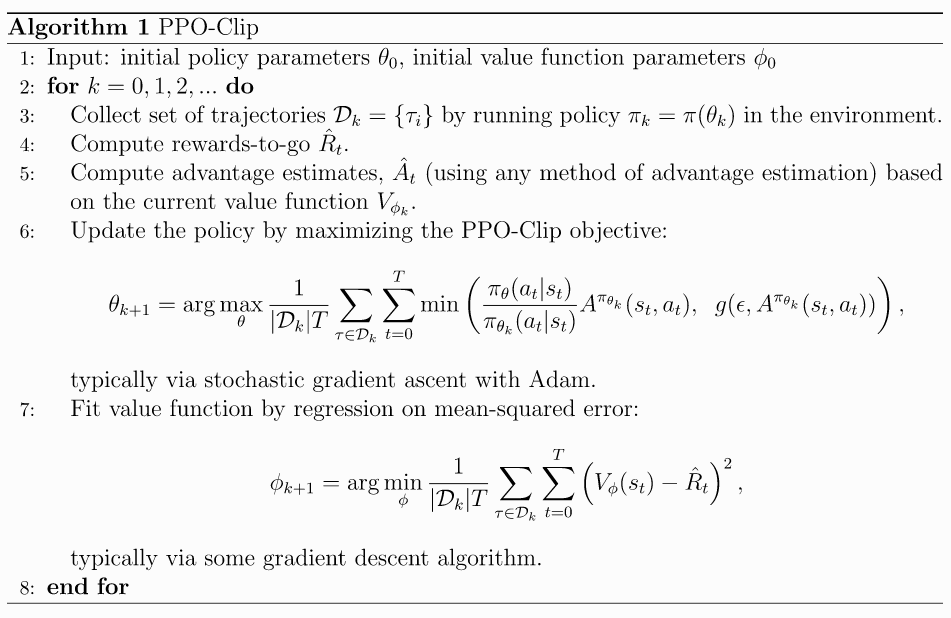

To account for exploration early on in training, we also add an entropy term to the loss function. By maximizing the policy entropy, the policy is encouraged to take random actions leading to better exploration. This eventually subsides as time progresses and the policy converges to a stable function.

In [1]:
# Activate the environment and load the packages
using Pkg
Pkg.activate(".")

using Flux
using Gym
import Reinforce.action
import Reinforce:run_episode
import Flux.params
using Flux.Tracker: grad, update!
using Flux: onehot
using Statistics
using Distributed
using Distributions
using LinearAlgebra
using Base.Iterators
using Random
using BSON
using BSON:@save,@load
using JLD

In [2]:
# Import helper functions

# The number of parallel actors that collect trajectories of experiences
num_processes = 1 # Let's keep it to just one actor for now
include("../common/policies.jl")
include("../common/utils.jl")
include("../common/buffer.jl")
include("rollout.jl")

collect_and_process_rollouts (generic function with 1 method)

We create a structure *Buffer* to collect and log information of different variables.

In [3]:
# Functions to initialize buffers to log trajectory information and data for logging performance
function initialize_episode_buffer()
    eb = Buffer()
    register(eb,"states")
    register(eb,"actions")
    register(eb,"rewards")
    register(eb,"next_states")
    register(eb,"dones")
    register(eb,"returns")
    register(eb,"advantages")
    register(eb,"log_probs")
    register(eb,"kl_params")
    
    return eb
end

function initialize_stats_buffer()
    sb = Buffer()
    register(sb,"rollout_rewards")
    
    return sb
end

initialize_stats_buffer (generic function with 1 method)

In [4]:
# Function to automatically select a policy given the environment
function get_policy(env_wrap::EnvWrap)
    if typeof(env_wrap.env._env.action_space) <: Gym.Space.Discrete
        return CategoricalPolicy(env_wrap)
    elseif typeof(env_wrap.env._env.action_space) <: Gym.Space.Box
        return DiagonalGaussianPolicy(env_wrap)
    else
        error("Policy type not supported")
    end
end

get_policy (generic function with 1 method)

In [5]:
# Define out hyperparameters
# Explanations of the PPO related parameters will be done shortly
# Environment Variables #
ENV_NAME = "Pendulum-v0"
EPISODE_LENGTH = 2000
terminate_horizon = false
resume = false # Whether to resume training from a previous checkpoint
# Policy parameters #
η = 1e-3 # Learning rate
STD = 0.0 # Standard deviation
# GAE parameters
γ = 0.99
λ = 0.95
# Optimization parameters
PPO_EPOCHS = 10
NUM_EPISODES = 100000
BATCH_SIZE = EPISODE_LENGTH
c₀ = 1.0
c₁ = 1.0
c₂ = 0.01
# PPO parameters
ϵ = 0.1
# FREQUENCIES
SAVE_FREQUENCY = 10 
VERBOSE_FREQUENCY = 5
global_step = 0

0

In [6]:
# Define environment wrapper
env_wrap = EnvWrap(ENV_NAME) # This structure will store all environment related information including the name and dynamics of the environment

# Obtain the policy type using the environment information
if resume == true
    policy = load_policy(env_wrap,"./weights/")
else
    policy = get_policy(env_wrap)
end

# Define buffers
episode_buffer = initialize_episode_buffer() # Stores trajectory variables of a rollout
stats_buffer = initialize_stats_buffer() # Stores statistics that are to be logged as performance metrics

# Define neural network optimizer
opt = ADAM(η)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

## Implementing the Loss function

We implement the clipped objective for PPO here. It is precisely equivalent to : 

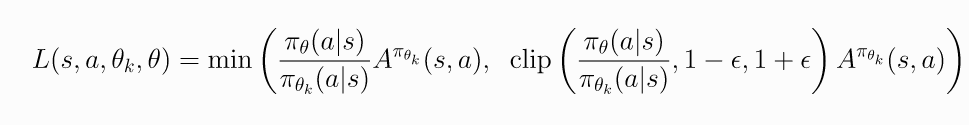

$A^{\pi_\theta}$ represents the **generalized advantage estimate**. $\epsilon$ is a hyperparameter signifying how far away we want the new policy to be from the old policy.

In [7]:
function loss(policy,states::Array,actions::Array,advantages::Array,returns::Array,old_log_probs::Array)
    new_log_probs = log_prob(policy,states,actions) # logπ_θ(a|s)
    
    # Surrogate loss computations
    ratio = exp.(new_log_probs .- old_log_probs) # π_θ(a|s) / π_θₖ(a|s)
    surr1 = ratio .* advantages
    surr2 = clamp.(ratio,(1.0 - ϵ),(1.0 + ϵ)) .* advantages
    policy_loss = mean(min.(surr1,surr2)) # Clipped objective as defined above
    
    value_predicted = policy.value_net(states) 
    value_loss = mean((value_predicted .- returns).^2) # ||V_ϕ(s_t) - Σγᵗr_t||
    
    entropy_loss = mean(entropy(policy,states)) # Entropy of policy under current parameters
    
    -c₀*policy_loss + c₁*value_loss - c₂*entropy_loss # We want to minimize this objective and hence the signs
end

loss (generic function with 1 method)

In [8]:
# Define an update function using PPO
function ppo_update(policy,states::Array,actions::Array,advantages::Array,returns::Array,old_log_probs::Array,kl_vars)
    model_params = params(get_policy_params(policy)...,get_value_params(policy)...)
    
    # Calculate gradients
    gs = Tracker.gradient(() -> loss(policy,states,actions,advantages,returns,old_log_probs),model_params)
    
    # Take a step of optimisation
    update!(opt,model_params,gs)
end

ppo_update (generic function with 1 method)

In [9]:
function train_step()    
    clear(episode_buffer) # Remove previously stored information of trajectories
    
    # Run current policy, obtain trajectory information to form a sample estimate of the clipped objective
    collect_and_process_rollouts(policy,episode_buffer,EPISODE_LENGTH,stats_buffer)
    
    idxs = partition(1:size(episode_buffer.exp_dict["states"])[end],BATCH_SIZE) # Break data into batches
    
    for epoch in 1:PPO_EPOCHS
        for i in idxs
            # Extract out information into mini-batches for training
            mb_states = episode_buffer.exp_dict["states"][:,i] 
            mb_actions = episode_buffer.exp_dict["actions"][:,i] 
            mb_advantages = episode_buffer.exp_dict["advantages"][:,i] 
            mb_returns = episode_buffer.exp_dict["returns"][:,i] 
            mb_log_probs = episode_buffer.exp_dict["log_probs"][:,i]
            mb_kl_vars = episode_buffer.exp_dict["kl_params"][i]
            
            # Obtain the kl divergence to log for changes in the policy
            kl_div = mean(kl_divergence(policy,mb_kl_vars,mb_states))
            # println("KL Sample : $(kl_div)")
            
            # Update the parameters
            ppo_update(policy,mb_states,mb_actions,mb_advantages,mb_returns,mb_log_probs,mb_kl_vars)
        end
    end
end

train_step (generic function with 1 method)

In [12]:
# Finally, the wrapper for everything we did above!
function train()
    for i in 1:NUM_EPISODES
        println(i)
        train_step()
        println("Mean rewards so far : $(mean(stats_buffer.exp_dict["rollout_rewards"]))")
        
        if i % SAVE_FREQUENCY == 0
            save_policy(policy,"./weights/")
        end
    end
end

train (generic function with 1 method)

In [14]:
# Train and see the rewards go up!
# Rollout rewards are the total rewards across all the sampled trajectories
# Mean rewards must go up with time as the policy improves
train()

1
Rollout rewards : 3370.6626244200343
Mean rewards so far : 3160.513057535907
2
Rollout rewards : 3123.516475433275
Mean rewards so far : 3157.430009027354
3
Rollout rewards : 3144.950470454309
Mean rewards so far : 3156.4700445217354
4
Rollout rewards : 3049.4699811494725
Mean rewards so far : 3148.827182852288
5
Rollout rewards : 3370.655697590806
Mean rewards so far : 3163.615750501522
6
Rollout rewards : 3282.12031754471
Mean rewards so far : 3171.0222859417213
7
Rollout rewards : 3183.9174035949054
Mean rewards so far : 3171.7808222742615
8
Rollout rewards : 3453.636117950609
Mean rewards so far : 3187.4394498118363
9
Rollout rewards : 3381.1352632579938
Mean rewards so far : 3197.6339663090025
10
Rollout rewards : 3428.752235343871
Mean rewards so far : 3209.1898797607455
Saved...
11
Rollout rewards : 3236.3692641711596
Mean rewards so far : 3210.484136161241
12
Rollout rewards : 3126.920641580754
Mean rewards so far : 3206.685795498492
13
Rollout rewards : 3142.5474082808873
Me

Mean rewards so far : 3333.4605838688644
103
Rollout rewards : 3434.549946365094


InterruptException: InterruptException:

# Test the policy


In [ ]:
using OpenAIGym

ENV_NAME = "Pendulum-v0"
TEST_STEPS = 10000
global steps_run = 0

# Pass path where weights are saved
LOAD_PATH = "./weights/"

# Define policy
env_wrap = EnvWrap(ENV_NAME)

# NOTE : An environment instance of OpenAIGym.jl is used here for the time being as rendering has a bug in Gym.jl
# env = make(ENV_NAME,:rgb)
# env.max_episode_steps = TEST_STEPS
env = GymEnv(ENV_NAME)
env.pyenv._max_episode_steps = TEST_STEPS
policy = load_policy(env_wrap,LOAD_PATH)

# Test Run Function
function test_run(env)
    global steps_run
    # testmode!(env)
    ep_r = 0.0
    
    s = OpenAIGym.reset!(env)
    println(s)
    for i in 1:TEST_STEPS
        if i % 1000 == 0
            println("---Resetting---")
            s = OpenAIGym.reset!(env)
            println(s)
            ep_r = 0.0
        end
        
        OpenAIGym.render(env)
        a = test_action(policy,s)
        a = convert.(Float64,a)

        if typeof(policy) <: DiagonalGaussianPolicy
            a = reshape(a,env_wrap.ACTION_SIZE)
        else
            # OpanAIGym hack
            a = a - 1.0f0
            a = Int64.(a)
        end

        # a = action(policy,s)
        # s_,r,_ = step!(env,a)
        r,s_ = OpenAIGym.step!(env,a)
        println(a)
        sleep(0.01)

        ep_r += r
        
        steps_run += 1
        
        s = s_
        if env.done
           # break 
           println("---Resetting---")
           s = OpenAIGym.reset!(env)
           println(ep_r)
           ep_r = 0.0
           continue
        end
    end
    ep_r
end

total_reward = test_run(env)

println("TOTAL STEPS :: $steps_run :: TOTAL REWARD :: $total_reward")

# Conclusion

The above explanation is very breif and is not into much of detail. You can go through the further readings below to understand the math and intricacies in detail.

# References

PPO Paper : https://arxiv.org/abs/1707.06347

Spinning up Documentation : https://spinningup.openai.com/en/latest/algorithms/ppo.html#proximal-policy-optimization

# Additional Reading

Deep RL by Berkeley : http://rail.eecs.berkeley.edu/deeprlcourse-fa18/static/slides/lec-9.pdf